---

**Nama:** Fathan Andi Kartagama

**NIM:** 122140055

**Repository GitHub:** [Github](https://github.com/pataanggs/Mulmed)

Notebook ini mencakup seluruh pengerjaan:

1. Rekaman & Analisis Suara Multi-Level  
2. Noise Reduction dengan Filtering  
3. Pitch Shifting & Audio Manipulation  
4. Audio Processing Chain (target loudness: **-16 LUFS**)  
5. Music Analysis & Remix

---

# Import dan Setup Folder

In [3]:
import os, math, io, copy, itertools, json, warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy.signal as sps
import soundfile as sf

from pydub import AudioSegment
import pyloudnorm as pyln

warnings.filterwarnings('ignore')

BASE_DIR = Path.cwd()
AUDIO_DIR = BASE_DIR / 'audio'
AUDIO_DIR.mkdir(exist_ok=True)

print('BASE_DIR:', BASE_DIR)
print('AUDIO_DIR:', AUDIO_DIR)


BASE_DIR: d:\Coding\Sistem-Teknologi-Multimedia\Worksheet-3
AUDIO_DIR: d:\Coding\Sistem-Teknologi-Multimedia\Worksheet-3\audio


---

# Utilities (I/O, DSP Helpers, Filtering)

In [4]:
# Fungsi untuk membaca file audio dan mengembalikan data dalam bentuk array numpy dan sampling rate-nya
def load_audio(path, sr=None, mono=True):
    y, sr_ = librosa.load(path, sr=sr, mono=mono)
    return y.astype(np.float32), sr_

# Fungsi untuk menyimpan data audio (array numpy) menjadi file .wav
def save_wav(path, y, sr):
    sf.write(str(path), y, sr)
    return str(path)

# Fungsi untuk mengubah data numpy menjadi AudioSegment (format pydub)
# Berguna untuk pemrosesan tambahan seperti fade in/out, gabung audio, dll
def np_to_audiosegment(y, sr):
    y = np.asarray(y)
    y16 = np.int16(np.clip(y, -1.0, 1.0) * 32767)  # konversi ke 16-bit PCM
    if y16.ndim == 1:
        channels = 1
        raw = y16.tobytes()
    else:
        if y16.shape[1] in (1,2):
            channels = y16.shape[1]
            raw = y16.reshape((-1,), order='C').tobytes()
        else:
            channels = 1
            raw = y16[:,0].tobytes()
    return AudioSegment(data=raw, sample_width=2, frame_rate=sr, channels=channels)

# Fungsi kebalikan dari np_to_audiosegment, yaitu mengubah AudioSegment menjadi array numpy
def audiosegment_to_np(seg):
    samples = np.array(seg.get_array_of_samples()).astype(np.int16)
    if seg.channels == 1:
        y = samples.astype(np.float32) / 32768.0
        return y, seg.frame_rate
    else:
        y = samples.reshape((-1, seg.channels)).astype(np.float32) / 32768.0
        return y, seg.frame_rate

# Fungsi untuk menampilkan waveform dan spektrogram dari sinyal audio
def plot_waveform_and_spectrogram(y, sr, title=''):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    # Menampilkan waveform (amplitudo terhadap waktu)
    times = np.arange(len(y)) / sr
    ax[0].plot(times, y)
    ax[0].set_title(f'Waveform {title}')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    ax[0].grid(True, alpha=0.3)
    
    # Menampilkan spektrogram (frekuensi terhadap waktu dalam skala log)
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))**2
    S_db = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='log', ax=ax[1])
    ax[1].set_title(f'Spectrogram (log-f) {title}')
    fig.colorbar(img, ax=ax[1], format='%+2.f dB')
    plt.tight_layout(); plt.show()

# Fungsi untuk menerapkan filter Butterworth (low-pass, high-pass, atau band-pass)
def butter_filter(y, sr, ftype='low', cutoff=1000.0, order=6, band=None):
    nyq = 0.5 * sr  # frekuensi Nyquist
    if ftype == 'low':
        Wn = cutoff / nyq
        b, a = sps.butter(order, Wn, btype='low', analog=False)
    elif ftype == 'high':
        Wn = cutoff / nyq
        b, a = sps.butter(order, Wn, btype='high', analog=False)
    elif ftype == 'band':
        low = band[0] / nyq
        high = band[1] / nyq
        b, a = sps.butter(order, [low, high], btype='bandpass', analog=False)
    else:
        raise ValueError('Invalid ftype')
    return sps.filtfilt(b, a, y)  # menggunakan filtfilt agar hasil lebih halus tanpa delay

# Fungsi untuk mempercepat atau memperlambat audio tanpa mengubah pitch
def time_stretch(y, rate):
    return librosa.effects.time_stretch(y, rate=rate)

# Fungsi untuk mengubah tinggi nada (pitch) tanpa mengubah durasi audio
def pitch_shift(y, sr, n_steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

# Fungsi untuk menormalkan loudness audio berdasarkan standar LUFS
def lufs_normalize(y, sr, target_lufs=-16.0):
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(y)
    gain = target_lufs - loudness
    y_norm = pyln.normalize.loudness(y, loudness, target_lufs)
    return y_norm, loudness, gain

# Fungsi untuk normalisasi puncak amplitudo (peak normalization)
def peak_normalize(y, peak=0.99):
    max_abs = np.max(np.abs(y)) + 1e-9
    return (y / max_abs) * peak

# Fungsi untuk melakukan dynamic range compression
# Menekan bagian keras dan menyeimbangkan dinamika audio
def compressor(y, sr, threshold_db=-20.0, ratio=4.0, attack_ms=10.0, release_ms=100.0, makeup_db=0.0):
    win = int(sr * 0.05)
    if win < 1: win = 1
    pad = (win//2, win - win//2)
    y_pad = np.pad(y, pad, mode='reflect')
    rms = np.sqrt(sps.convolve(y_pad**2, np.ones(win)/win, mode='valid'))
    rms_db = 20*np.log10(np.maximum(rms, 1e-9))
    over_db = np.maximum(rms_db - threshold_db, 0.0)
    gain_reduction_db = over_db * (1.0 - 1.0/ratio)
    
    # Pengaturan attack dan release time
    a = np.exp(-1.0 / (sr * (attack_ms/1000.0)))
    r = np.exp(-1.0 / (sr * (release_ms/1000.0)))
    gr_sm = np.zeros_like(gain_reduction_db)
    
    # Perhitungan gain reduction dengan smoothing
    for i, g in enumerate(gain_reduction_db):
        if i == 0:
            gr_sm[i] = g
        else:
            if g > gr_sm[i-1]:
                gr_sm[i] = a * gr_sm[i-1] + (1-a) * g
            else:
                gr_sm[i] = r * gr_sm[i-1] + (1-r) * g
    
    gr_lin = 10 ** (-(gr_sm)/20.0)
    
    # FIX: Pastikan ukuran sama dengan menggunakan minimum length
    min_len = min(len(y), len(gr_lin))
    y_out = y[:min_len] * gr_lin[:min_len]
    y_out *= 10 ** (makeup_db/20.0)
    
    # Pad jika y_out lebih pendek dari y original
    if len(y_out) < len(y):
        y_out = np.pad(y_out, (0, len(y)-len(y_out)))
    return y_out

# Fungsi untuk menghilangkan bagian sinyal dengan level di bawah ambang batas tertentu
def noise_gate(y, threshold_db=-50.0):
    win = 1024
    eps = 1e-9
    y2 = y.copy()
    for i in range(0, len(y), win):
        frame = y[i:i+win]
        rms = np.sqrt(np.mean(frame**2) + eps)
        db = 20*np.log10(rms + eps)
        if db < threshold_db:
            y2[i:i+win] = 0.0  # nol-kan frame yang terlalu pelan
    return y2

# Fungsi untuk memotong bagian diam (silence) di awal dan akhir rekaman
def trim_silence(y, top_db=40):
    yt, idx = librosa.effects.trim(y, top_db=top_db)
    return yt, idx

# Fungsi untuk memperkirakan tempo (BPM) dari sinyal audio
def estimate_bpm(y, sr):
    tempo = librosa.beat.tempo(y=y, sr=sr, hop_length=512, aggregate=np.median)
    return float(tempo[0])

# Fungsi untuk mendeteksi nada dasar (key) musik dari sinyal audio
def estimate_key(y, sr):
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma = chroma.mean(axis=1)
    chroma = chroma / (np.max(chroma) + 1e-9)
    
    # Template profil mayor dan minor untuk perbandingan
    major = np.array([6.35,2.23,3.48,2.33,4.38,4.09,2.52,5.19,2.39,3.66,2.29,2.88])
    minor = np.array([6.33,2.68,3.52,5.38,2.60,3.53,2.54,4.75,3.98,2.69,3.34,3.17])
    major = major / major.max()
    minor = minor / minor.max()
    keys = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    
    # Bandingkan skor tiap key dengan profil mayor/minor
    best_score = -1.0
    best = ('C','major')
    for i in range(12):
        maj_score = np.dot(chroma, np.roll(major, i))
        min_score = np.dot(chroma, np.roll(minor, i))
        if maj_score >= min_score and maj_score > best_score:
            best_score = maj_score; best = (keys[i], 'major')
        elif min_score > maj_score and min_score > best_score:
            best_score = min_score; best = (keys[i], 'minor')
    return best


| No | Nama Fungsi                       | Tujuan / Kegunaan Utama                  | Keterangan Singkat                                     |
| -- | --------------------------------- | ---------------------------------------- | ------------------------------------------------------ |
| 1  | `load_audio()`                    | Membaca file audio                       | Mengembalikan data audio dan sampling rate             |
| 2  | `save_wav()`                      | Menyimpan audio ke file `.wav`           | Menggunakan library `soundfile`                        |
| 3  | `np_to_audiosegment()`            | Konversi NumPy → AudioSegment            | Untuk efek seperti fade atau crossfade                 |
| 4  | `audiosegment_to_np()`            | Konversi AudioSegment → NumPy            | Kebalikan dari fungsi sebelumnya                       |
| 5  | `plot_waveform_and_spectrogram()` | Visualisasi sinyal audio                 | Menampilkan waveform dan spectrogram                   |
| 6  | `butter_filter()`                 | Filtering audio (low/high/band-pass)     | Menghapus noise di frekuensi tertentu                  |
| 7  | `time_stretch()`                  | Mengubah kecepatan audio                 | Tidak mengubah pitch                                   |
| 8  | `pitch_shift()`                   | Mengubah tinggi nada (pitch)             | Tidak mengubah durasi                                  |
| 9  | `lufs_normalize()`                | Normalisasi loudness (LUFS)              | Menyeimbangkan volume sesuai persepsi manusia          |
| 10 | `peak_normalize()`                | Normalisasi berdasarkan puncak amplitudo | Menjaga level tertinggi audio di bawah clipping        |
| 11 | `compressor()`                    | Meratakan dinamika suara                 | Mengecilkan bagian keras dan memperjelas bagian lembut |
| 12 | `noise_gate()`                    | Menghilangkan noise saat jeda            | Menutup bagian dengan volume di bawah threshold        |
| 13 | `trim_silence()`                  | Memotong bagian diam                     | Membersihkan awal dan akhir rekaman                    |
| 14 | `estimate_bpm()`                  | Deteksi tempo lagu (BPM)                 | Mengukur kecepatan ketukan                             |
| 15 | `estimate_key()`                  | Deteksi nada dasar musik                 | Mengidentifikasi key mayor/minor                       |


---

# Soal 1. Rekaman dan Analisis Suara Multi-Level

Loaded: Berita.wav, durasi: 44.16s, sr: 48000


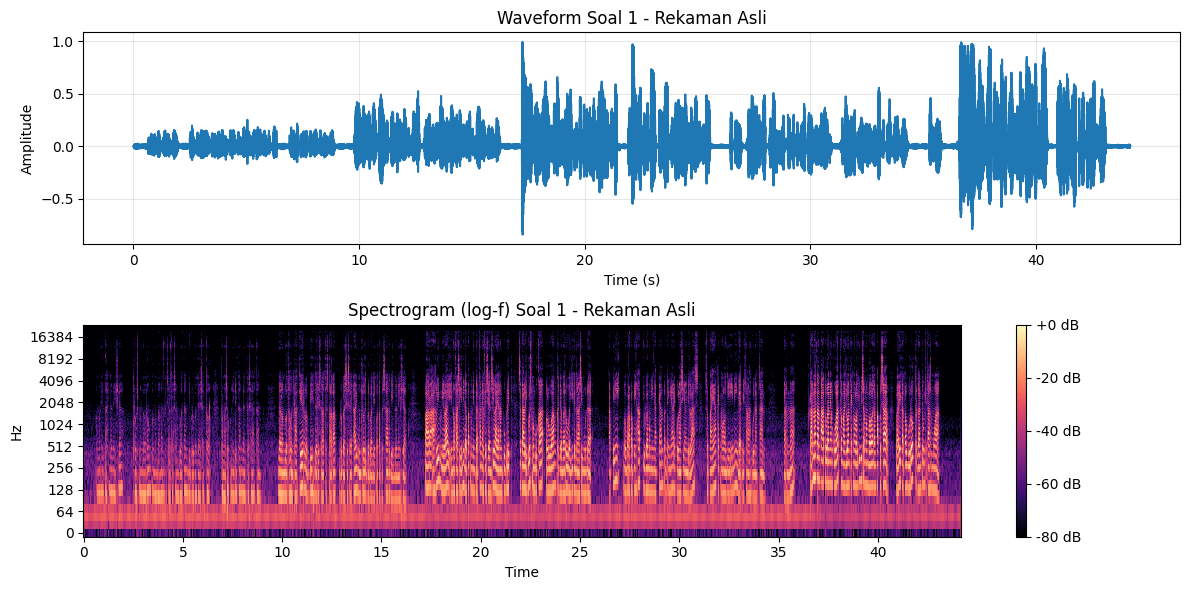

Sesudah resampling: 44.16 detik @ 16000 Hz


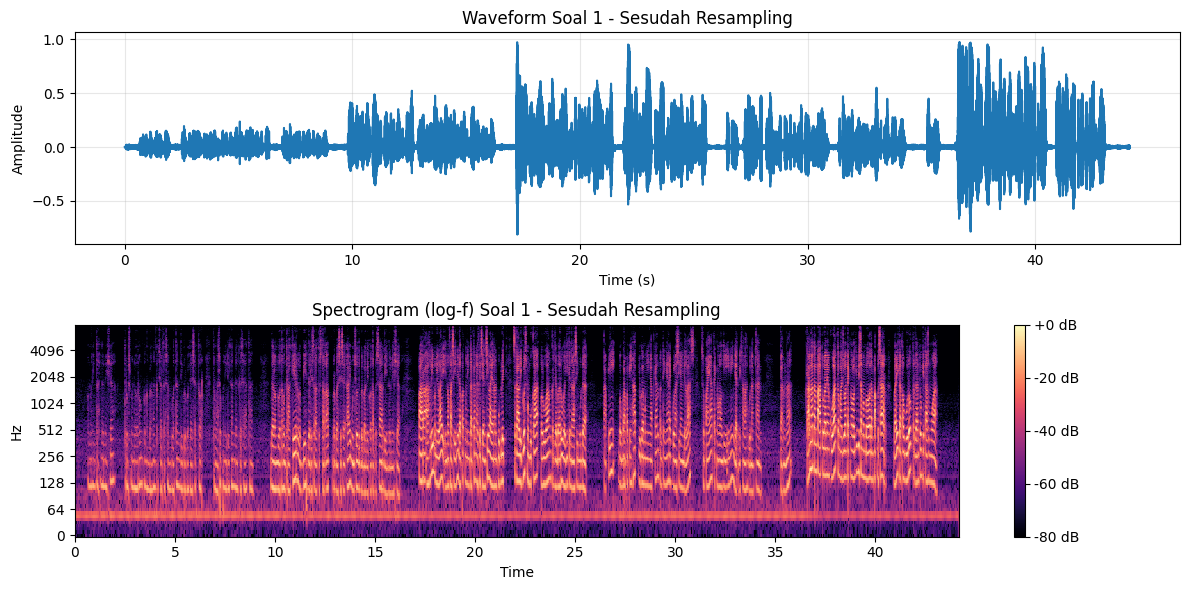

In [10]:
path_soal1 = AUDIO_DIR / 'Berita.wav'
assert path_soal1.exists(), f'File tidak ditemukan: {path_soal1}. Silakan taruh rekaman Anda terlebih dahulu.'
y1, sr1 = load_audio(path_soal1, sr=None, mono=True)
print(f'Loaded: {path_soal1.name}, durasi: {len(y1)/sr1:.2f}s, sr: {sr1}')

plot_waveform_and_spectrogram(y1, sr1, title='Soal 1 - Rekaman Asli')

target_sr = 16000
# Use scipy resampling to avoid resampy dependency
y1_rs = librosa.resample(y=y1, orig_sr=sr1, target_sr=target_sr, res_type='soxr_hq')
save_wav(AUDIO_DIR / 'soal1_resampled.wav', y1_rs, target_sr)
print('Sesudah resampling:', len(y1_rs)/target_sr, 'detik @', target_sr, 'Hz')
plot_waveform_and_spectrogram(y1_rs, target_sr, title='Soal 1 - Sesudah Resampling')


Setelah dibandingkan, bentuk waveform dari rekaman asli dan hasil resampling kelihatan hampir sama yang mana urutan dan dinamika suaranya ga berubah. Bedanya cuma ada di bagian frekuensi: rekaman asli punya spektrum sampai sekitar 16 kHz, sedangkan hasil resampling cuma sampai 4 kHz karena frekuensi samplingnya diturunkan jadi 16 kHz. Akibatnya, suara jadi sedikit kehilangan detail di High Frequency, tapi bagian utama suara manusia (sekitar 100–3000 Hz) tetap jelas (Bisa dilihat pada spectogram intensitas warna pada frekuensi tersebut cukup terang)

---

# Soal 2. Noise Reduction dengan Filtering

Loaded: 1015.wav, durasi: 12.93s, sr: 44100


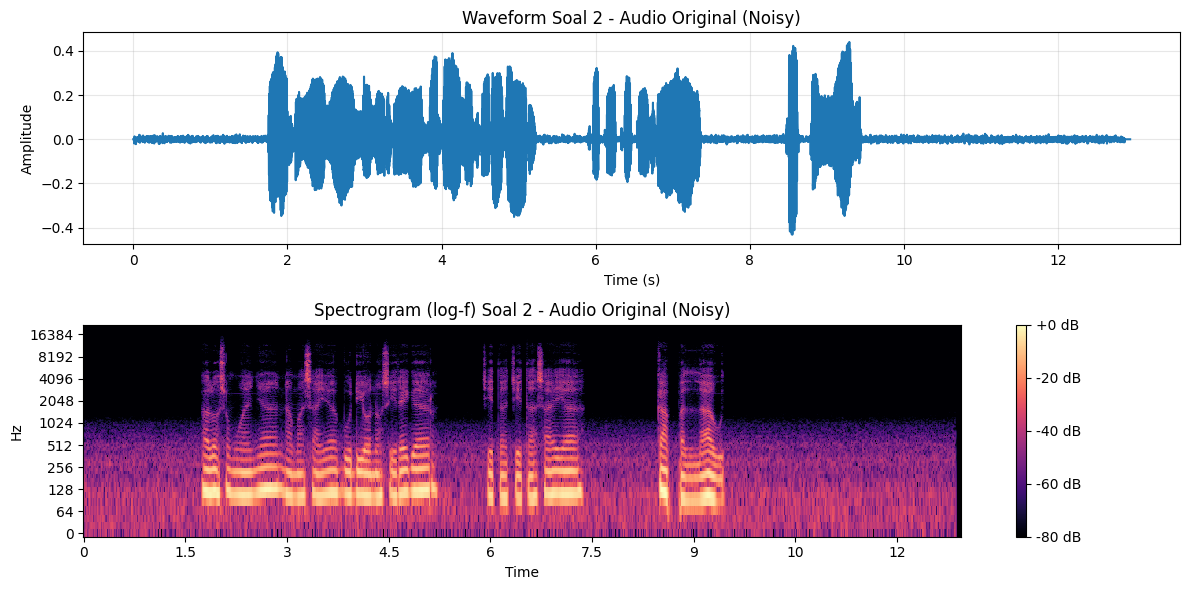


=== HIGH-PASS FILTER (Menghilangkan Noise Rendah) ===


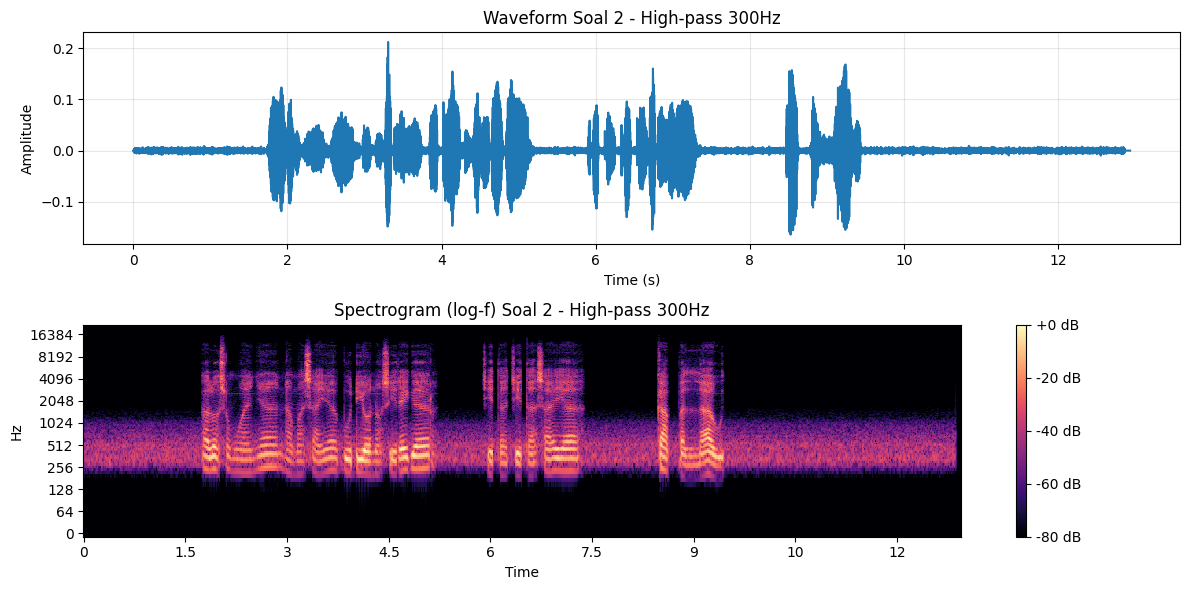

✓ Saved: soal2_highpass_300Hz.wav


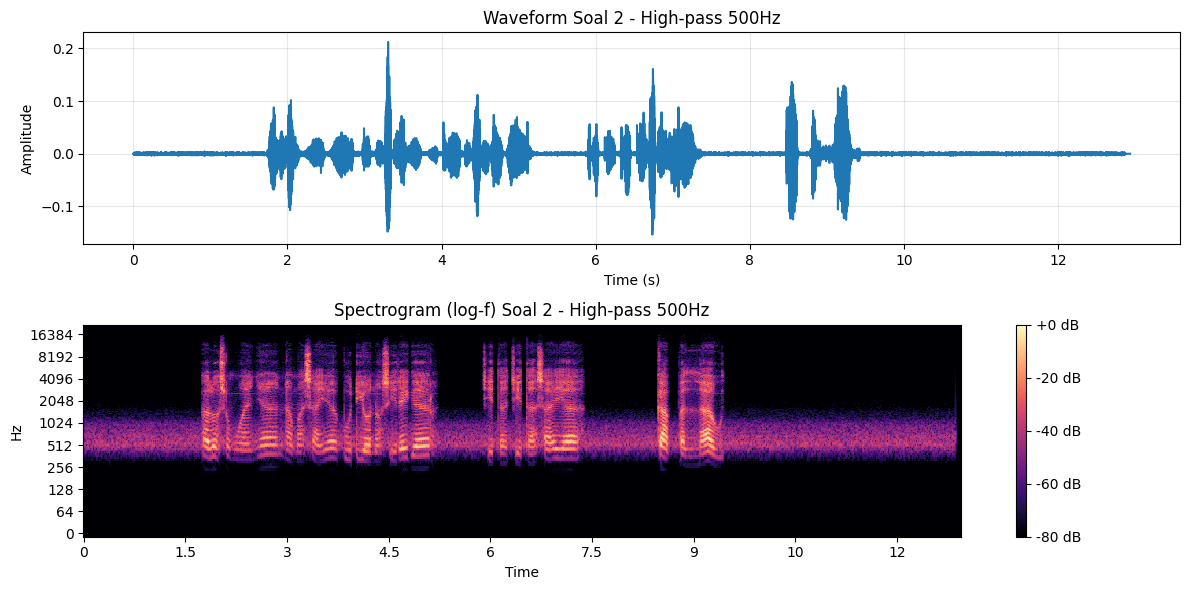

✓ Saved: soal2_highpass_500Hz.wav


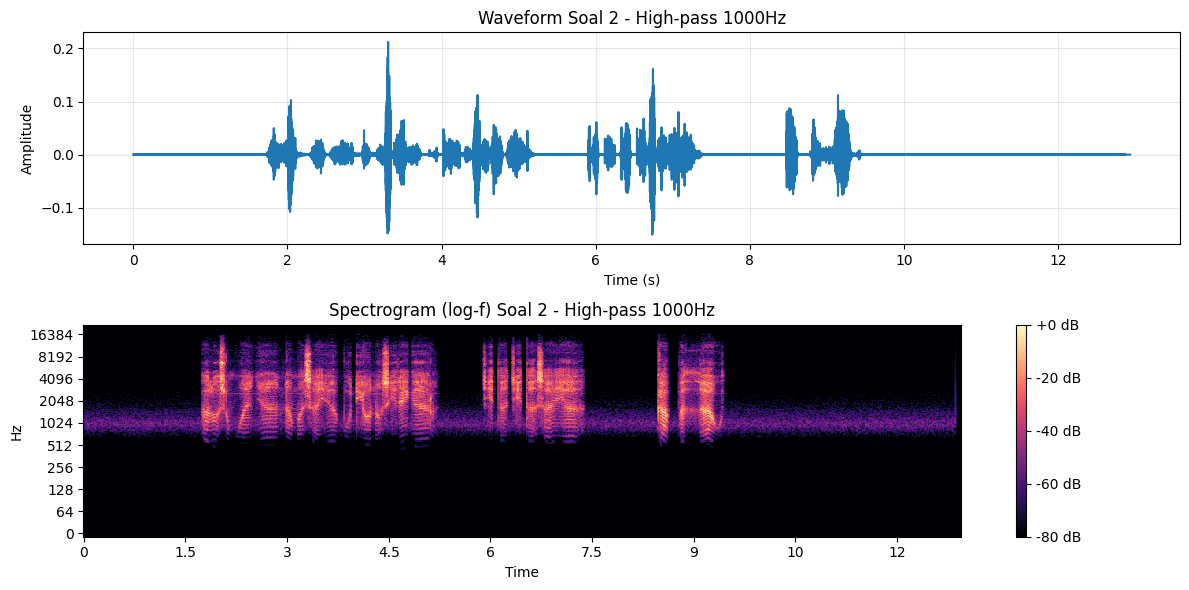

✓ Saved: soal2_highpass_1000Hz.wav

=== LOW-PASS FILTER (Menghilangkan Noise Tinggi) ===


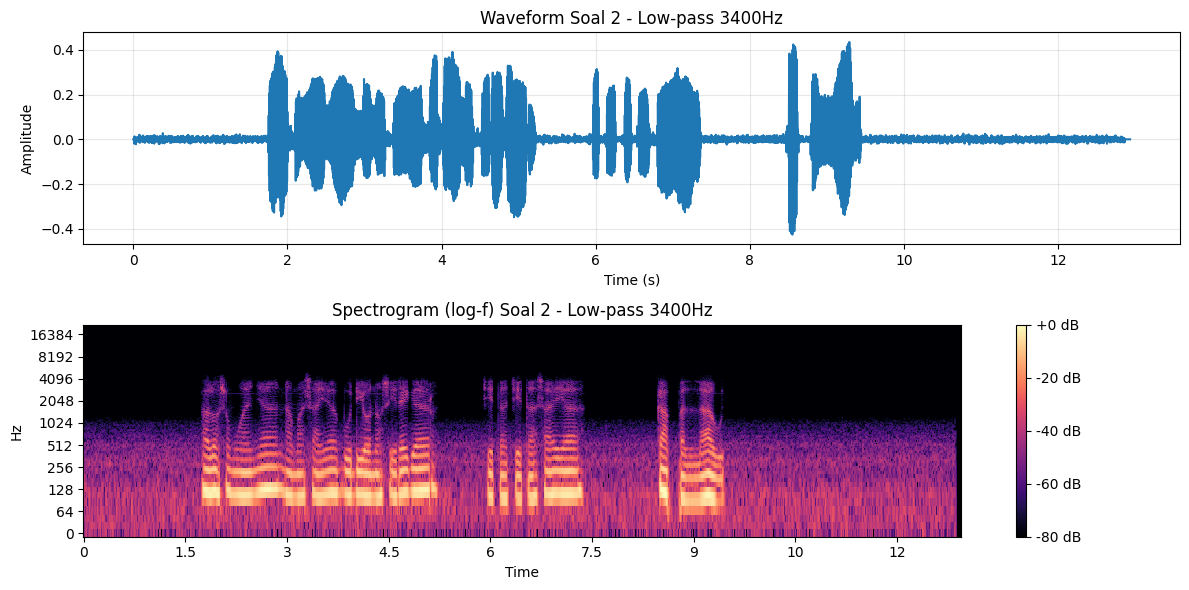

✓ Saved: soal2_lowpass_3400Hz.wav


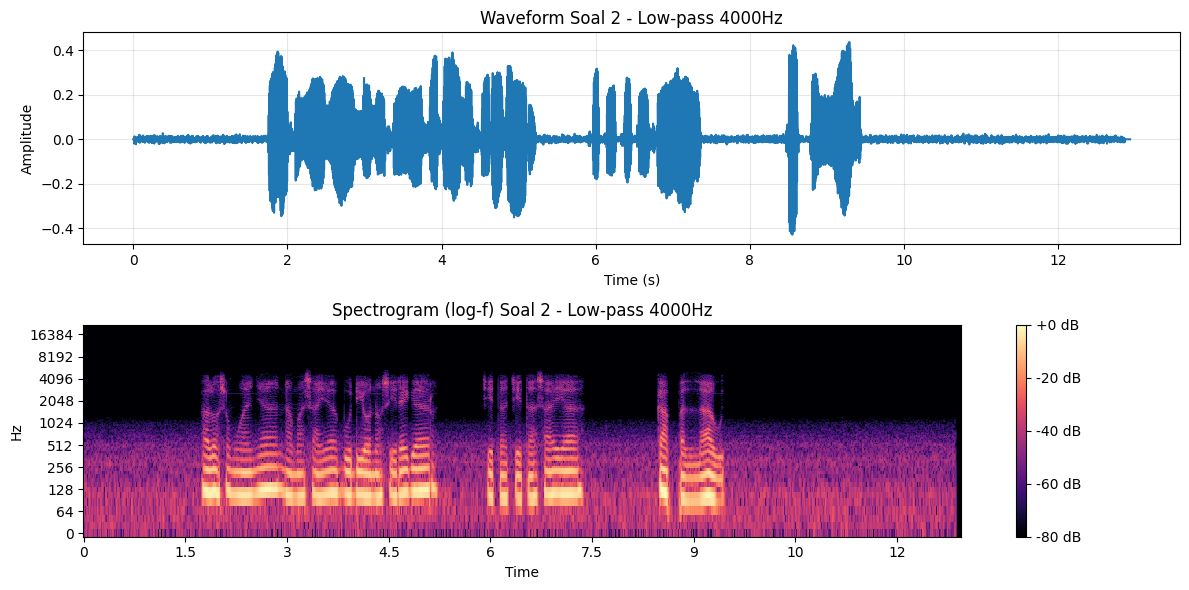

✓ Saved: soal2_lowpass_4000Hz.wav


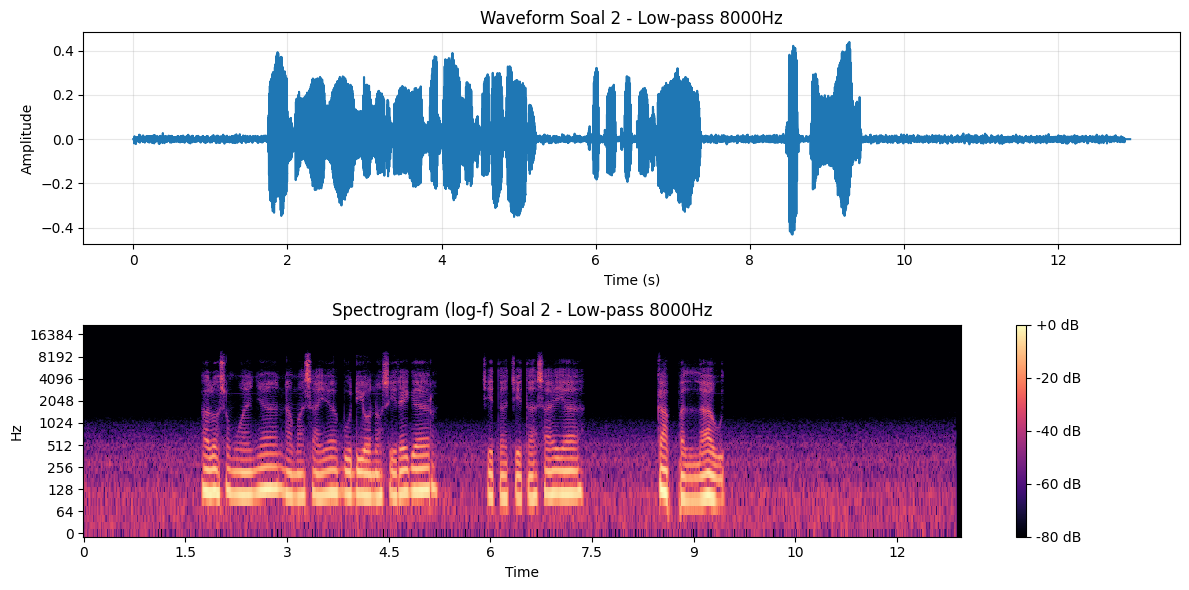

✓ Saved: soal2_lowpass_8000Hz.wav

=== BAND-PASS FILTER (Fokus ke Frekuensi Speech) ===


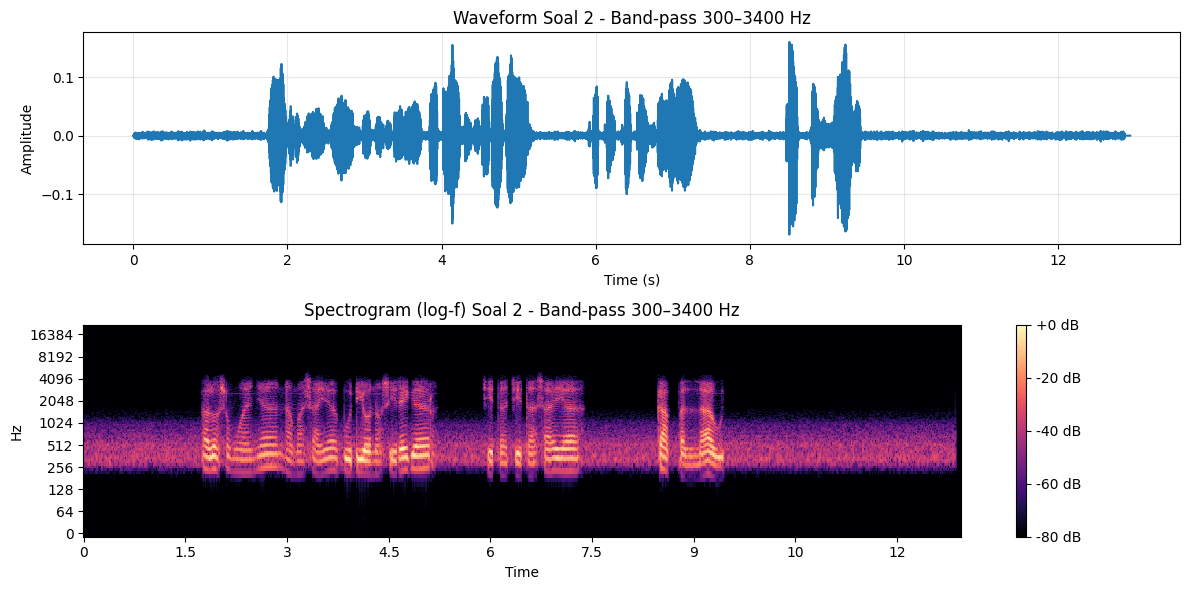

✓ Saved: soal2_bandpass_300-3400Hz.wav


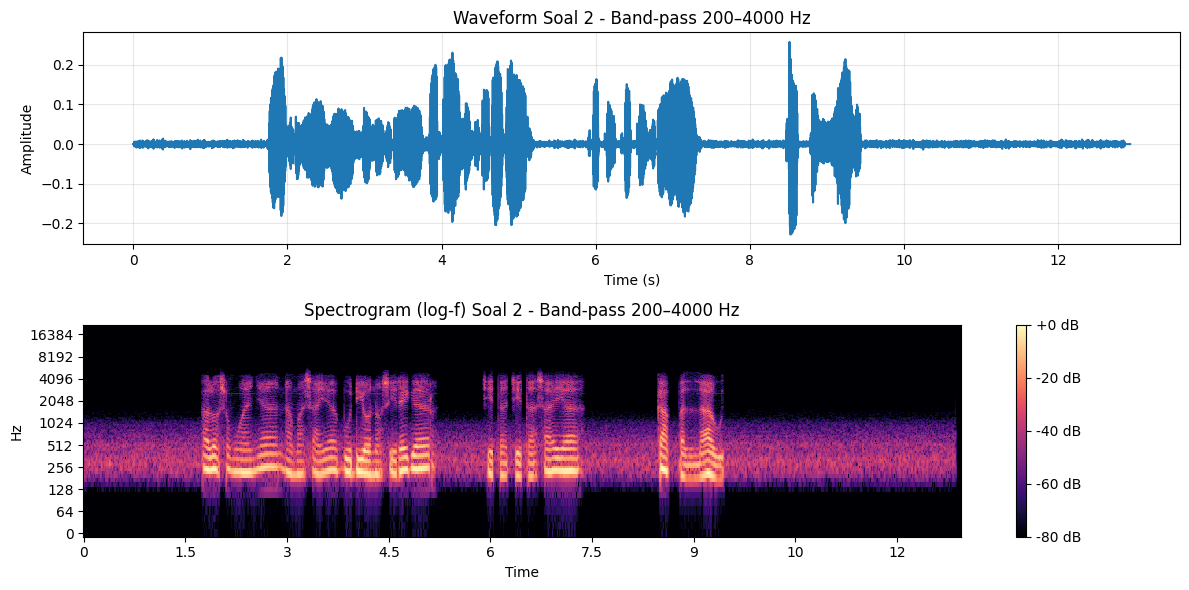

✓ Saved: soal2_bandpass_200-4000Hz.wav


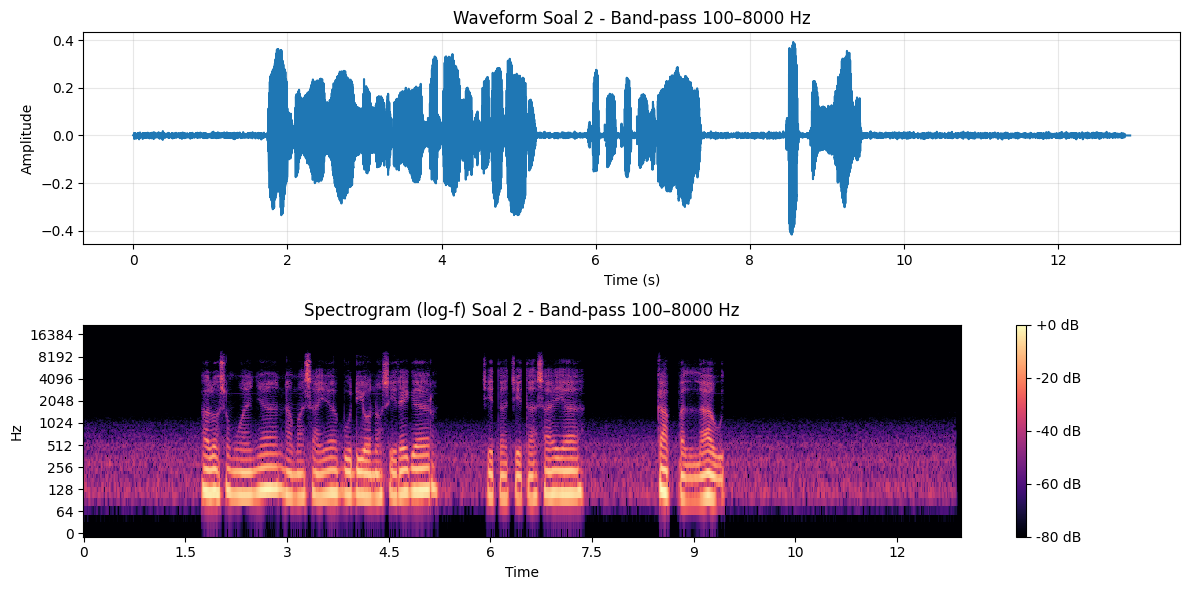

✓ Saved: soal2_bandpass_100-8000Hz.wav


In [16]:
path_soal2 = AUDIO_DIR / '1015.wav'
assert path_soal2.exists(), f'File tidak ditemukan: {path_soal2}. Letakkan rekaman audio Anda.'
y2, sr2 = load_audio(path_soal2, sr=None, mono=True)
print(f'Loaded: {path_soal2.name}, durasi: {len(y2)/sr2:.2f}s, sr: {sr2}')

plot_waveform_and_spectrogram(y2, sr2, title='Soal 2 - Audio Original (Noisy)')

# High-Pass Filter - Paling efektif untuk menghilangkan noise rendah (hum, rumble)
print("\n=== HIGH-PASS FILTER (Menghilangkan Noise Rendah) ===")
hp_cutoffs = [300, 500, 1000]

for c in hp_cutoffs:
    y_hp = butter_filter(y2, sr2, ftype='high', cutoff=c, order=6)
    save_wav(AUDIO_DIR / f'soal2_highpass_{c}Hz.wav', y_hp, sr2)
    plot_waveform_and_spectrogram(y_hp, sr2, title=f'Soal 2 - High-pass {c}Hz')
    print(f"✓ Saved: soal2_highpass_{c}Hz.wav")

# Low-Pass Filter - Untuk menghilangkan noise tinggi (hiss, white noise)
print("\n=== LOW-PASS FILTER (Menghilangkan Noise Tinggi) ===")
lp_cutoffs = [3400, 4000, 8000]

for c in lp_cutoffs:
    y_lp = butter_filter(y2, sr2, ftype='low', cutoff=c, order=6)
    save_wav(AUDIO_DIR / f'soal2_lowpass_{c}Hz.wav', y_lp, sr2)
    plot_waveform_and_spectrogram(y_lp, sr2, title=f'Soal 2 - Low-pass {c}Hz')
    print(f"✓ Saved: soal2_lowpass_{c}Hz.wav")

# Band-Pass Filter - Kombinasi terbaik untuk speech (fokus ke frekuensi vokal)
print("\n=== BAND-PASS FILTER (Fokus ke Frekuensi Speech) ===")
bands = [(300, 3400), (200, 4000), (100, 8000)]

for b in bands:
    y_bp = butter_filter(y2, sr2, ftype='band', band=b, order=6)
    save_wav(AUDIO_DIR / f'soal2_bandpass_{b[0]}-{b[1]}Hz.wav', y_bp, sr2)
    plot_waveform_and_spectrogram(y_bp, sr2, title=f'Soal 2 - Band-pass {b[0]}–{b[1]} Hz')
    print(f"✓ Saved: soal2_bandpass_{b[0]}-{b[1]}Hz.wav")



---

# Analisis Hasil Filtering Audio

## 1. Jenis Noise

Noise yang digunakan pada percobaan ini adalah **white noise**, yaitu jenis noise yang memiliki energi menyebar merata di seluruh frekuensi. Karena sifatnya yang menyebar luas, white noise terdengar seperti desisan konstan dan cukup sulit dihilangkan hanya dengan satu jenis filter. Maka dari itu, pengujian dilakukan dengan beberapa tipe filter (high-pass, low-pass, dan band-pass) untuk melihat mana yang paling efektif mereduksi noise tanpa merusak kualitas suara

---

## 2. Analisis Per Filter

### a. High-pass Filter

Filter high-pass bekerja dengan menghilangkan frekuensi rendah dan hanya membiarkan frekuensi tinggi lewat.
Dari hasil pengamatan, filter ini cukup berhasil mengurangi dengungan dan getaran di bagian bawah (sekitar 0–200 Hz). Namun, ketika cutoff dinaikkan hingga 500 Hz atau 1000 Hz, suara saya mulai kehilangan karakter alaminya. Ucapan terdengar tipis karena sebagian besar energi suara saya berada di bawah 500 Hz

### b. Low-pass Filter

Low-pass filter berfungsi sebaliknya, yaitu menahan frekuensi tinggi dan membiarkan frekuensi rendah lewat.
Filter ini cukup efektif untuk mengurangi desisan (hiss) dari white noise pada area frekuensi tinggi. Namun, hasilnya masih menyisakan noise rendah, dan meski ucapan tetap terdengar, suara jadi **boomy**. Secara umum, low-pass filter kurang efektif jika digunakan sendiri untuk white noise karena gangguannya muncul di seluruh spektrum

### c. Band-pass Filter

Band-pass filter mengizinkan frekuensi di antara dua nilai cutoff tertentu untuk lewat dan menahan sisanya.
Filter ini terbukti paling efektif untuk sinyal ucapan. Pada rentang **300–3400 Hz**, noise di frekuensi rendah dan tinggi dapat ditekan secara bersamaan. Hasilnya, suara terdengar jauh lebih bersih tanpa banyak kehilangan kejelasan

---

**TLDR**
- Dari semua percobaan, band-pass filter dengan rentang 300–3400 Hz adalah yang paling efektif untuk mereduksi white noise
- Filter ini mampu menekan dengung di frekuensi rendah dan desisan di frekuensi tinggi sekaligus, tanpa mengubah karakter utama suara
- Sementara itu, high-pass hanya bagus untuk menghilangkan noise rendah tapi bikin suara jadi tipis,
dan low-pass mengurangi noise tinggi tapi membuat suara jadi boomy dan kurang jernih

---

# Soal 3. Pitch Shifting dan Audio Manipulation

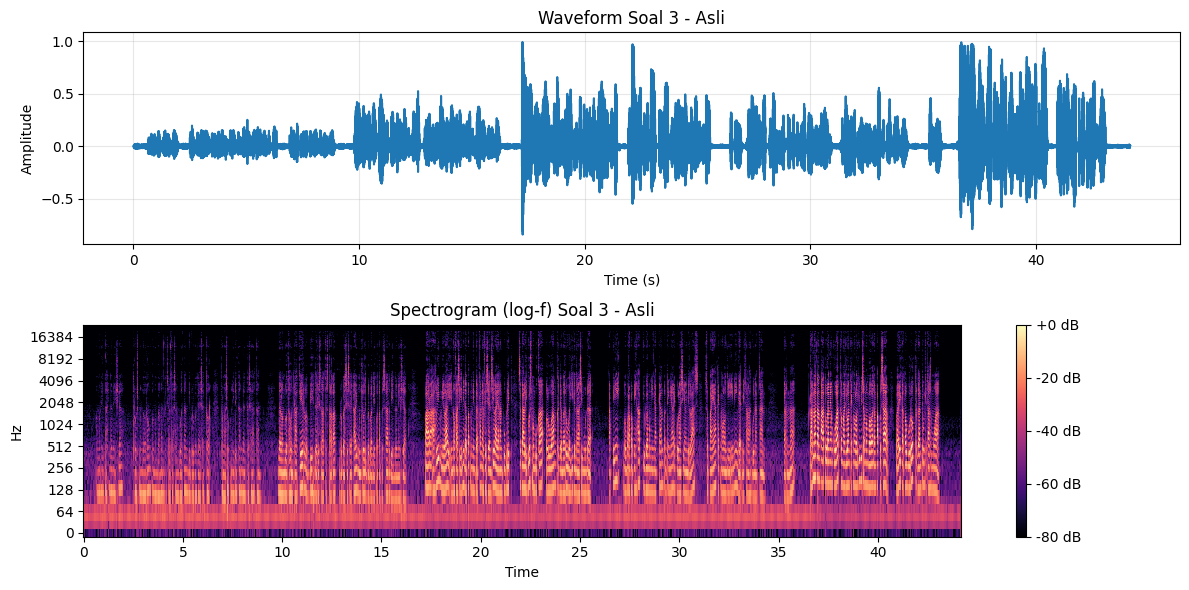

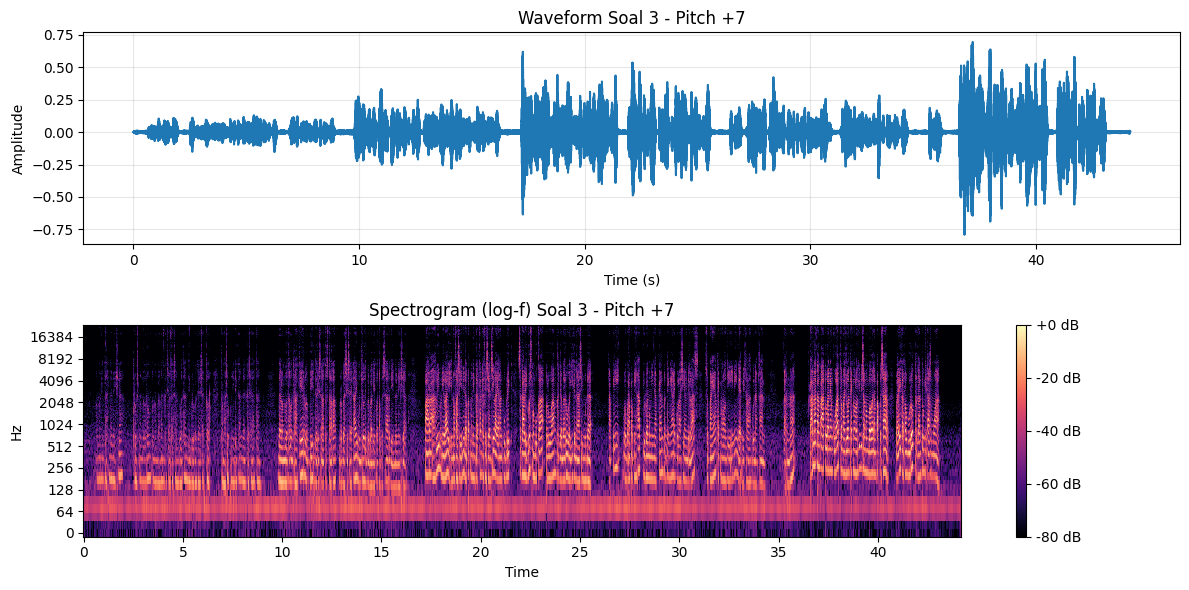

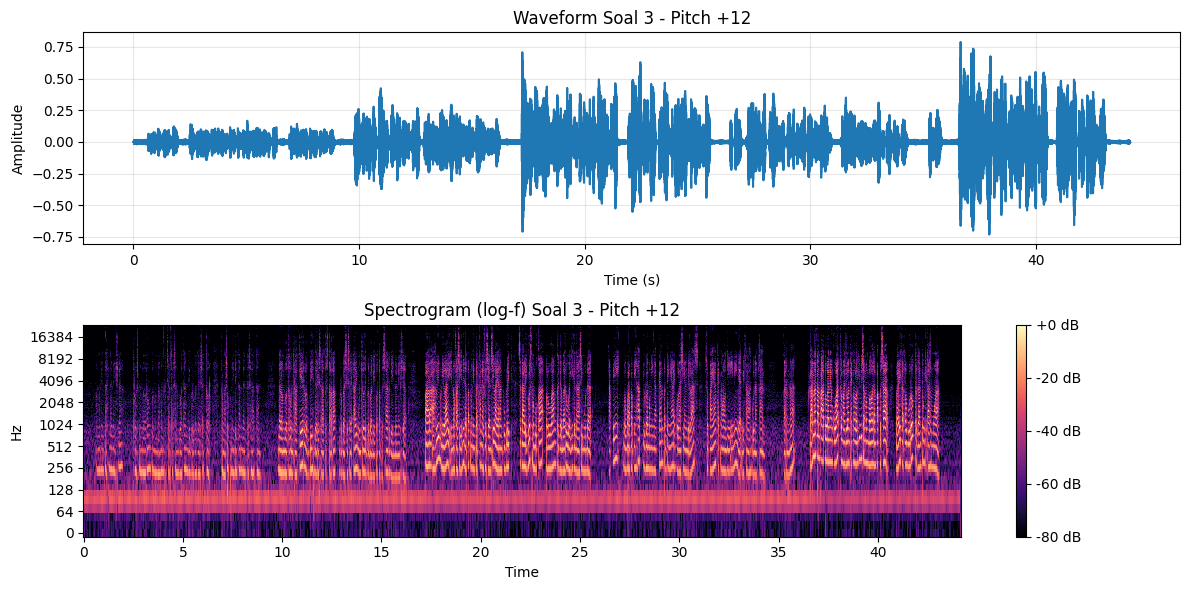

<_io.BufferedRandom name='d:\\Coding\\Sistem-Teknologi-Multimedia\\Worksheet-3\\audio\\soal3_mix_p7_p12.wav'>

In [19]:
y3, sr3 = load_audio(AUDIO_DIR / 'Berita.wav', sr=None, mono=True)
y3_p7  = pitch_shift(y3, sr3, n_steps=+7)
y3_p12 = pitch_shift(y3, sr3, n_steps=+12)
save_wav(AUDIO_DIR / 'soal3_pitch_+7.wav',  y3_p7,  sr3)
save_wav(AUDIO_DIR / 'soal3_pitch_+12.wav', y3_p12, sr3)
plot_waveform_and_spectrogram(y3, sr3, title='Soal 3 - Asli')
plot_waveform_and_spectrogram(y3_p7, sr3, title='Soal 3 - Pitch +7')
plot_waveform_and_spectrogram(y3_p12, sr3, title='Soal 3 - Pitch +12')

seg_p7  = np_to_audiosegment(y3_p7, sr3)
seg_p12 = np_to_audiosegment(y3_p12, sr3)
mix = seg_p7.append(seg_p12, crossfade=500)
mix_path = AUDIO_DIR / 'soal3_mix_p7_p12.wav'
mix.export(mix_path, format='wav')


---

## Analisis Soal No.3 Pitch Shifting

### 1. Parameter yang Dipakai

* **Fungsi:** `librosa.effects.pitch_shift()`
* **Parameter utama:**

  * `y3` → data audio asli
  * `sr3` → sampling rate audio
  * `n_steps = +7` dan `+12` → menaikkan pitch sebanyak 7 dan 12 semitone (1 oktaf = 12 semitone)
* **Tujuan:** buat naikin tinggi nada suara tanpa ngubah kecepatannya (durasi tetep sama).

---

### 2. Perbedaan Visual

| Jenis Audio   | Ciri Waveform                                                         | Ciri Spektrogram                                                           |
| ------------- | --------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **Asli**      | Amplitudo seimbang antara frekuensi rendah dan tinggi                 | Energi dominan di sekitar 100–4000 Hz (rentang umum suara manusia)         |
| **Pitch +7**  | Bentuk gelombang masih sama, tapi pola harmoniknya agak geser ke atas | Frekuensi dominan naik sekitar setengah oktaf                              |
| **Pitch +12** | Waveform kelihatan mirip tapi sedikit lebih rapat                     | Energi geser lebih tinggi (sekitar satu oktaf), warna terang makin ke atas |

---

### 3. Dampak ke Kualitas Suara

* **Pitch +7:** suara jadi lebih tinggi, tapi masih cukup jelas dan masih cukup enak didengar
* **Pitch +12:** nada makin tinggi kayak suara chipmunk, agak nyaring tapi jadi kurang natural
* **Intinya:** makin besar nilai `n_steps`, makin tinggi nadanya tapi bisa bikin suara terasa aneh

---

# Soal 4 .Audio Processing Chain (EQ → Fade/Gain → Normalization → Compression → Noise Gate → Silence Trim)

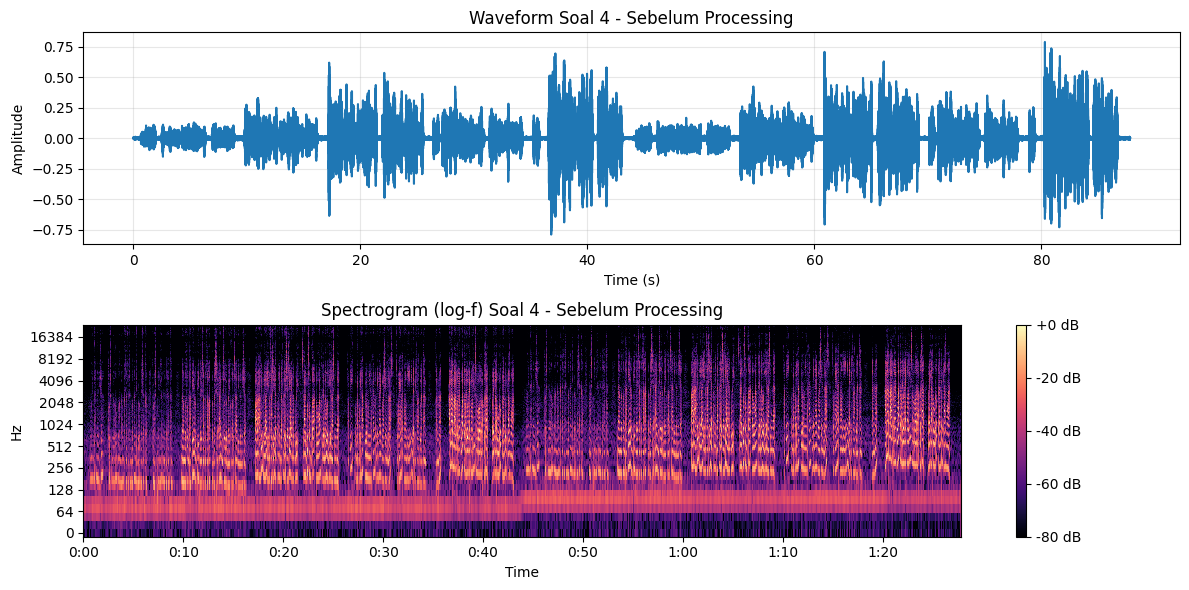

LUFS sebelum: -22.47 dB, gain kompensasi: 6.47 dB
Saved: d:\Coding\Sistem-Teknologi-Multimedia\Worksheet-3\audio\soal4_processed_-16LUFS.wav
Saved: d:\Coding\Sistem-Teknologi-Multimedia\Worksheet-3\audio\soal4_processed_-16LUFS.wav


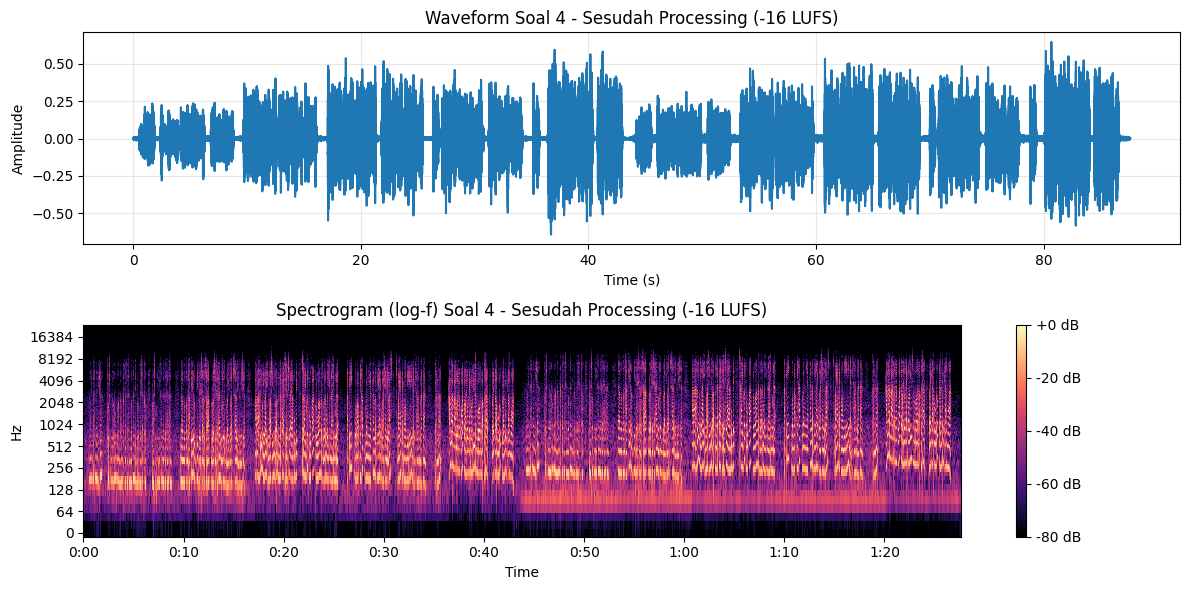

In [5]:
src_path = AUDIO_DIR / 'soal3_mix_p7_p12.wav'
assert src_path.exists(), 'Jalankan Soal 3 terlebih dahulu.'
y4, sr4 = load_audio(src_path, sr=None, mono=True)
plot_waveform_and_spectrogram(y4, sr4, title='Soal 4 - Sebelum Processing')

y4_eq_lowcut  = butter_filter(y4, sr4, ftype='high', cutoff=80, order=4)
y4_eq_band    = butter_filter(y4_eq_lowcut, sr4, ftype='band', band=(100, 8000), order=4)
y4_eq = y4_eq_band

seg = np_to_audiosegment(y4_eq, sr4)
seg = seg.fade_in(200).fade_out(300)
y4_eq_fade, _ = audiosegment_to_np(seg)

y4_lufs, lufs_before, gain_db = lufs_normalize(y4_eq_fade, sr4, target_lufs=-16.0)
print(f'LUFS sebelum: {lufs_before:.2f} dB, gain kompensasi: {gain_db:.2f} dB')

y4_comp = compressor(y4_lufs, sr4, threshold_db=-20.0, ratio=3.0, attack_ms=8.0, release_ms=120.0, makeup_db=0.0)
y4_gate = noise_gate(y4_comp, threshold_db=-55.0)
y4_final, idx = trim_silence(y4_gate, top_db=40)

out_path = AUDIO_DIR / 'soal4_processed_-16LUFS.wav'
save_wav(out_path, y4_final, sr4)
print('Saved:', out_path)
plot_waveform_and_spectrogram(y4_final, sr4, title='Soal 4 - Sesudah Processing (-16 LUFS)')


- Setelah dilakukan proses normalisasi dengan standar ```-16 LUFS```, dinamika suara menjadi lebih seimbang dan stabil di seluruh durasi rekaman
- Jika sebelumnya bagian pelan terdengar samar dan bagian keras terlalu dominan, kini volume terdengar lebih rata dan konsisten

- Berbeda dengan normalisasi puncak (peak normalization) yang hanya menyesuaikan amplitudo tertinggi, normalisasi LUFS memperhitungkan persepsi pendengaran manusia sehingga hasilnya terasa lebih natural dan nyaman didengar
- Secara visual juga, waveform tampak lebih padat dan merata, sementara pada spectrogram, distribusi energi lebih seragam di seluruh rentang frekuensi

---

# Soal 5. Music Analysis & Remix (BPM, Key, Time-Stretch, Pitch-Shift, Crossfade)

Song1: dur 60.0s @ 48000 Hz
Song2: dur 60.0s @ 48000 Hz
Song1 BPM: 133.9, Key: F# minor
Song2 BPM: 160.7, Key: F minor
Song1 BPM: 133.9, Key: F# minor
Song2 BPM: 160.7, Key: F minor
Saved: d:\Coding\Sistem-Teknologi-Multimedia\Worksheet-3\audio\soal5_remix_final.wav
Saved: d:\Coding\Sistem-Teknologi-Multimedia\Worksheet-3\audio\soal5_remix_final.wav


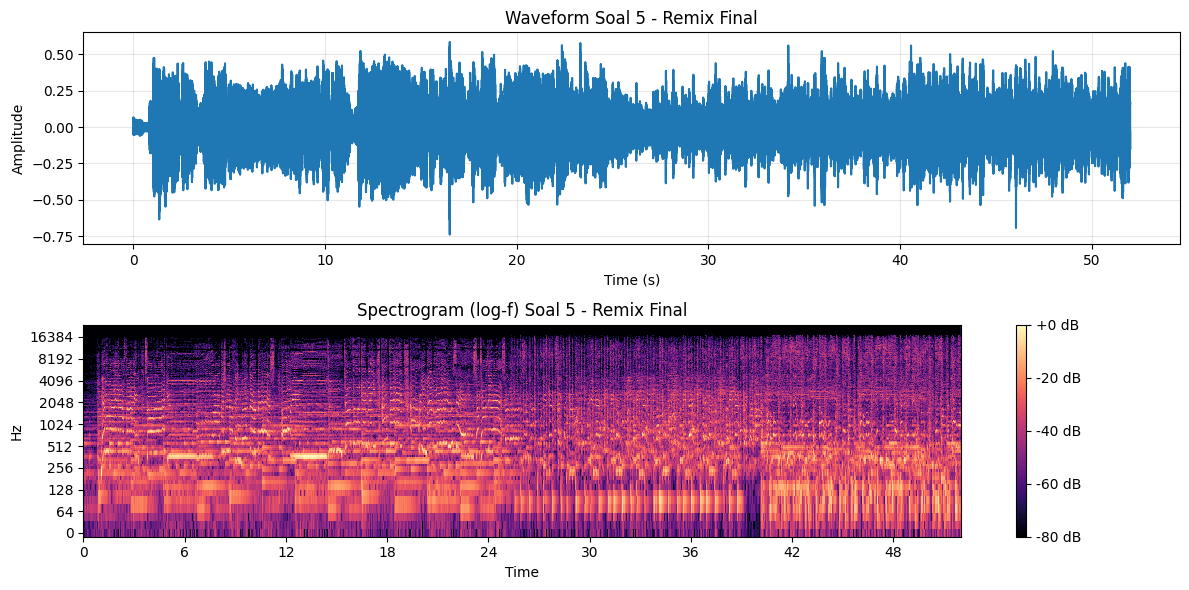

In [6]:
song1_path = AUDIO_DIR / 'Adele.wav'
song2_path = AUDIO_DIR / 'PharrelW.wav'
assert song1_path.exists() and song2_path.exists(), 'Letakkan song1.wav dan song2.wav (±1 menit) di folder audio/'
yA, srA = load_audio(song1_path, sr=None, mono=True)
yB, srB = load_audio(song2_path, sr=None, mono=True)
print(f'Song1: dur {len(yA)/srA:.1f}s @ {srA} Hz')
print(f'Song2: dur {len(yB)/srB:.1f}s @ {srB} Hz')

bpmA = estimate_bpm(yA, srA)
bpmB = estimate_bpm(yB, srB)
keyA = estimate_key(yA, srA)
keyB = estimate_key(yB, srB)
print(f'Song1 BPM: {bpmA:.1f}, Key: {keyA[0]} {keyA[1]}')
print(f'Song2 BPM: {bpmB:.1f}, Key: {keyB[0]} {keyB[1]}')

target_bpm = (bpmA + bpmB) / 2.0
rateA = bpmA / target_bpm
rateB = bpmB / target_bpm
yA_ts = time_stretch(yA, rate=rateA)
yB_ts = time_stretch(yB, rate=rateB)

note_to_int = {'C':0,'C#':1,'D':2,'D#':3,'E':4,'F':5,'F#':6,'G':7,'G#':8,'A':9,'A#':10,'B':11}
def semitone_diff(a, b):
    return (note_to_int[b] - note_to_int[a]) % 12
tonicA, modeA = keyA
tonicB, modeB = keyB
nA = 0
nB = semitone_diff(tonicB, tonicA)
yA_key = yA_ts
yB_key = pitch_shift(yB_ts, srB, n_steps=nB)

segA = np_to_audiosegment(yA_key, srA)
segB = np_to_audiosegment(yB_key, srB)
min_len_ms = min(len(segA), len(segB))
segA = segA[:min_len_ms]
segB = segB[:min_len_ms]
half = min_len_ms // 2
A_head = segA[:half]
B_tail = segB[half:]
mix5 = A_head.append(B_tail, crossfade=3000)
mix5_path = AUDIO_DIR / 'soal5_remix_final.wav'
mix5.export(mix5_path, format='wav')
print('Saved:', mix5_path)
mix_np, sr_mix = audiosegment_to_np(mix5)
plot_waveform_and_spectrogram(mix_np, srA, title='Soal 5 - Remix Final')


- Langkah pertama adalah mendeteksi tempo (BPM) dan nada dasar (key) dari kedua lagu supaya bisa disesuaikan

- Tempo disamakan menggunakan time stretching, jadi lagu yang lebih cepat diperlambat sedikit dan yang lebih lambat dipercepat, tapi durasi dan pitch-nya tetap sama
- Lalu, nada dasar dari lagu kedua diubah dengan pitch shifting agar serasi dengan lagu pertama, biar nggak terdengar fals saat digabung

- Setelah dua lagu punya tempo dan nada yang pas, bagian awal lagu pertama dan akhir lagu kedua digabung menggunakan crossfade selama 3 detik. Teknik ini bikin perpindahan antar lagu jadi sedikit halus

---

# Lampiran

- [ChatGPT](https://chatgpt.com/share/68f10a87-e834-8006-8d83-46488abce03e)
- [Github](https://github.com/pataanggs/Mulmed)
- [Librosa](https://librosa.org/doc/latest/index.html)
- [PyDub](https://pydub.com/)
- [Scipy](https://docs.scipy.org/doc/scipy/index.html)


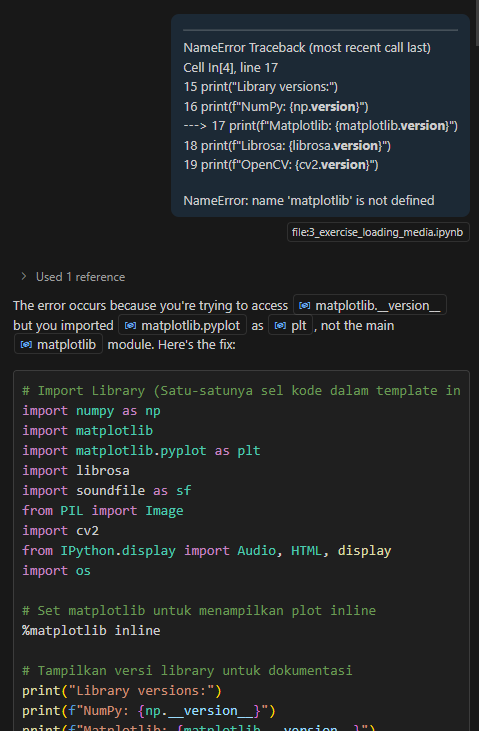
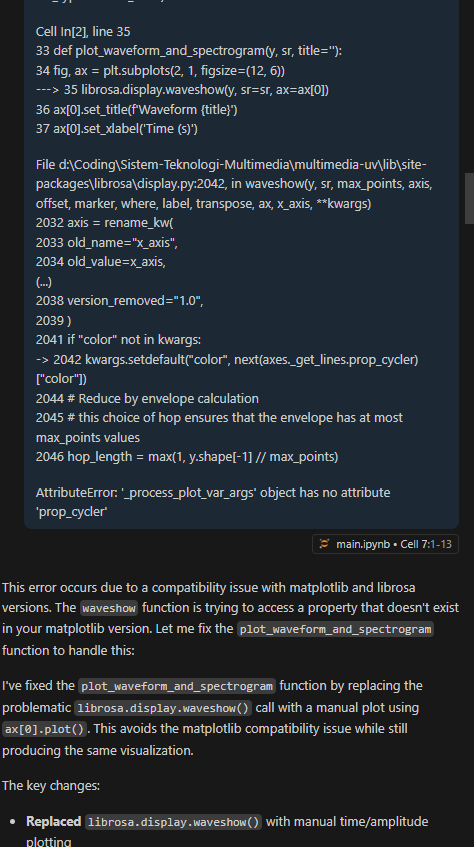
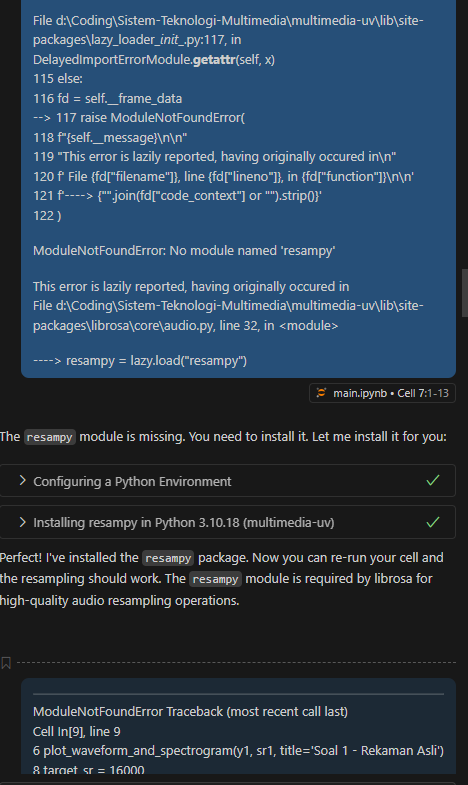
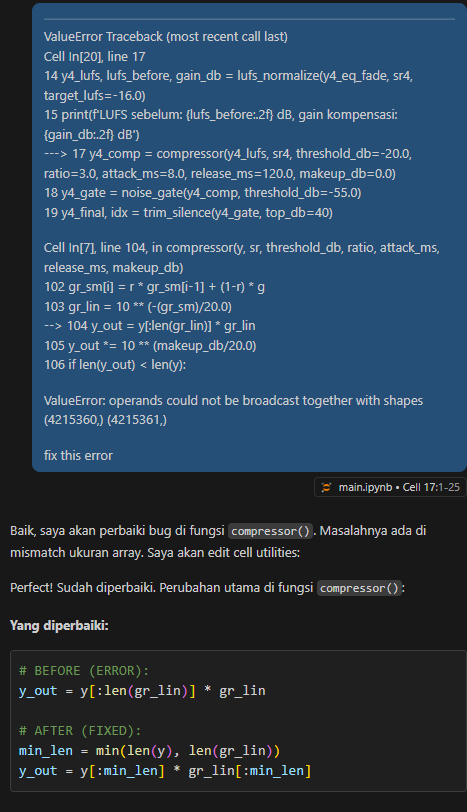
